<a href="https://colab.research.google.com/github/Swethaa-sri/project1/blob/main/credit__default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
## reading dataset
credit = pd.read_csv('UCI_Credit_Card.csv')
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
credit.shape

(30000, 25)

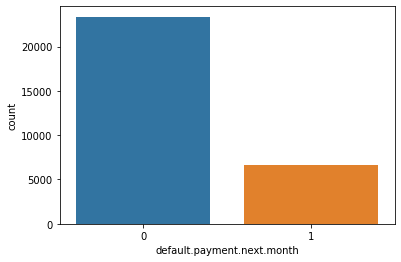

In [5]:
sns.countplot(x = credit['default.payment.next.month'], data = credit)
# 1 = yes , 0 = no

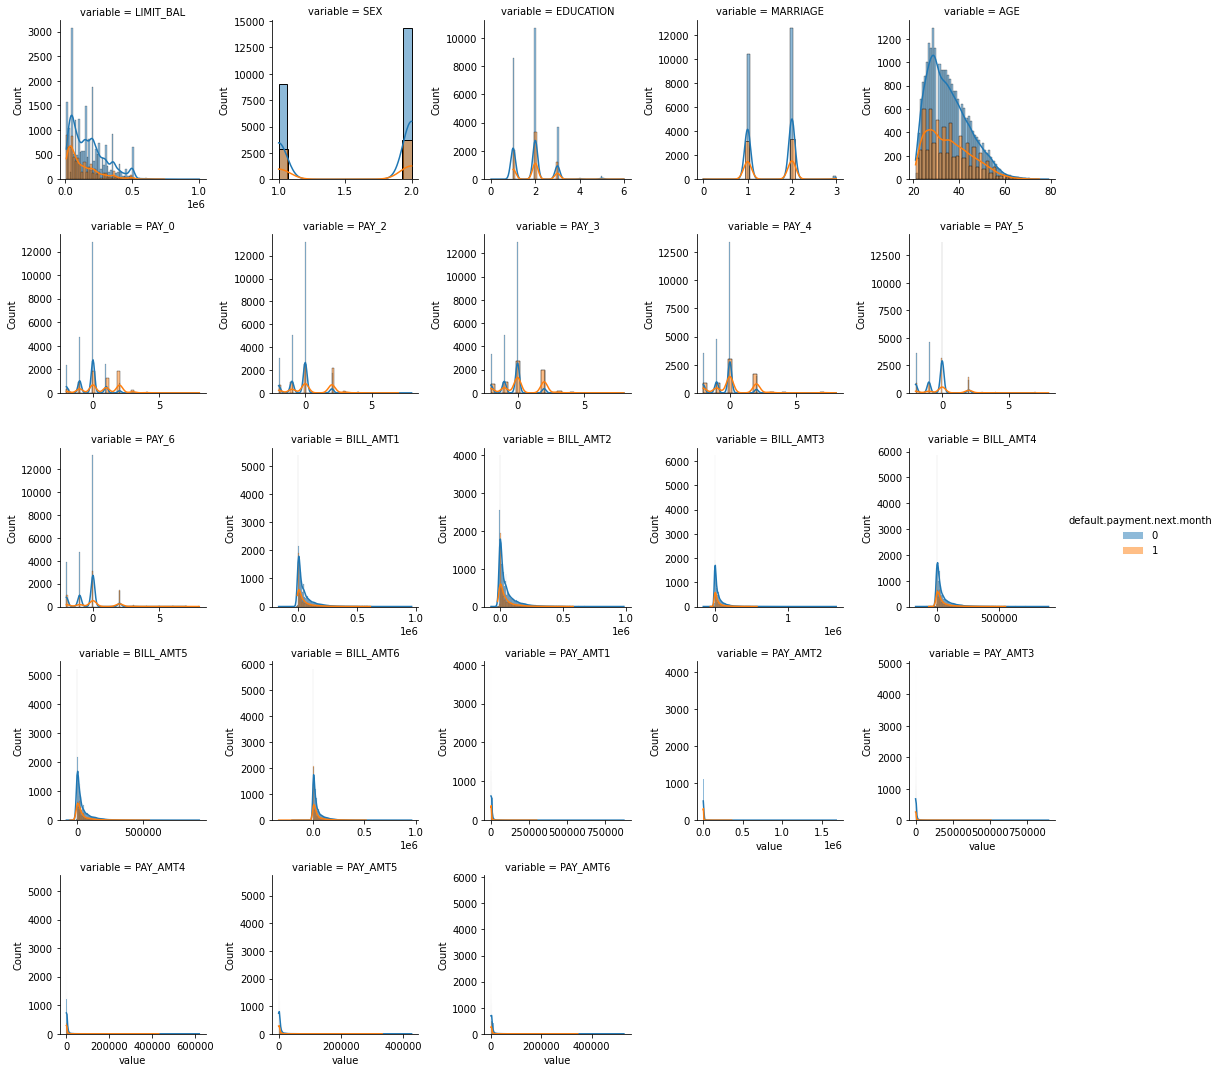

In [6]:
output = 'default.payment.next.month'

# Let's do a little EDA
cols = [ f for f in credit.columns if credit.dtypes[ f ] != "object"]
cols.remove( "ID")
cols.remove( output )

f = pd.melt( credit, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.histplot, "value", kde=True).add_legend()

Observations:

1) Defaults have a higher proportion of Lower LIMIT_BAL values

2) NonDefaults have a higher proportion of Females (Sex=2)

3) NonDefaults have a higher proportion of MoreEducated (EDUCATION=1 or 2)

4) NonDefaults have a higher proportion of Singles (MARRIAGE=2)

5) NonDefaults have a higher proportion of people 30-40years

6) NonDefaults have a MUCH higher proportion of zero or negative PAY_X 
variables (this means that being current or ahead of payments is associated with not defaulting in the following month).
 
This is a strong relationship as the distribution are more separated - so we expect the PAY_X to be important!

In [7]:
def ChiSquaredTestOfIndependence( df, inputVar, Outcome_Category ):
    # Useful to have this wrapped in a function
    # The ChiSquaredTest of Independence - 
    # has a null hypothesis: the OutcomeCategory is independent of the inputVar
    # So we create a test-statistic which is a measure of the difference between 
    # "expected" i.e. what we WOULD observe if the OutcomeCategory WAS independent of the inputVar
    # "observed" i.e. what the data actually shows
    # the p-value returned is the probability of seeing this test-statistic if the null-hypothesis is true
    Outcome_Category_Table = df.groupby( Outcome_Category )[ Outcome_Category ].count().values
    Outcome_Category_Ratios = Outcome_Category_Table / sum( Outcome_Category_Table )
    possibleVals = df[inputVar].unique()
    observed = []
    expected = []
    for possible in possibleVals:
        countsInCategories = df[ df[ inputVar ] == possible ].groupby( Outcome_Category )[Outcome_Category].count().values
        if( len(countsInCategories) != len( Outcome_Category_Ratios ) ):
            print("Error! The class " + str( possible) +" of \'" + inputVar + "\' does not contain all values of \'" + Outcome_Category + "\'" )
            return
        elif( min(countsInCategories) < 5 ):
            print("Chi Squared Test needs at least 5 observations in each cell!")
            print( inputVar + "=" + str(possible) + " has insufficient data")
            print( countsInCategories )
            return
        else:
            observed.append( countsInCategories )   
            expected.append( Outcome_Category_Ratios * len( df[df[ inputVar ] == possible ]))
    observed = np.array( observed )
    expected = np.array( expected )
    chi_squared_stat = ((observed - expected)**2 / expected).sum().sum()
    degOfF = (observed.shape[0] - 1 ) *(observed.shape[1] - 1 ) 
    #crit = stats.chi2.ppf(q = 0.95,df = degOfF) 
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degOfF)
    print("Calculated test-statistic is %.2f" % chi_squared_stat )
    print("If " + Outcome_Category + " is indep of " + inputVar + ", this has prob %.2e of occurring" % p_value )
    #t_stat, p_val, doF, expArray = stats.chi2_contingency(observed= observed, correction=False)
    #print("Using built-in stats test: outputs")
    #print("test-statistic=%.2f, p-value=%.2f, degsOfFreedom=%d" % ( t_stat, p_val, doF ) )

In [8]:
ChiSquaredTestOfIndependence( credit, "SEX", output )

Calculated test-statistic is 47.91
If default.payment.next.month is indep of SEX, this has prob 4.47e-12 of occurring


##### "default" is not independent of "SEX".

In [9]:
ChiSquaredTestOfIndependence( credit, "EDUCATION", output )   

Error! The class 0 of 'EDUCATION' does not contain all values of 'default.payment.next.month'


In [10]:
# There aren't enough values in the Education class =0. 
# We'll probably find the same for the non-typical-looking values Education = 4, 5, 6.
# How many of each do we have?

print("We have %d with EDUCATION=0" % len(credit.loc[ credit["EDUCATION"]==0]))
print("We have %d with EDUCATION=4" % len(credit.loc[ credit["EDUCATION"]==4]))
print("We have %d with EDUCATION=5" % len(credit.loc[ credit["EDUCATION"]==5]))
print("We have %d with EDUCATION=6" % len(credit.loc[ credit["EDUCATION"]==6]))

We have 14 with EDUCATION=0
We have 123 with EDUCATION=4
We have 280 with EDUCATION=5
We have 51 with EDUCATION=6


In [11]:
# Since we have 30k samples, let's just put these non-typical Education instances all into the EDUCATION=4 class and continue 
credit["EDUCATION_Corr"] = credit["EDUCATION"].apply( lambda x: x if ((x>0) and (x<4)) else 4 )
ChiSquaredTestOfIndependence( credit, "EDUCATION_Corr", output ) 
cols.remove("EDUCATION")
cols.append("EDUCATION_Corr")

ChiSquaredTestOfIndependence( credit, "MARRIAGE", output ) 

Calculated test-statistic is 160.41
If default.payment.next.month is indep of EDUCATION_Corr, this has prob 0.00e+00 of occurring
Calculated test-statistic is 35.66
If default.payment.next.month is indep of MARRIAGE, this has prob 8.83e-08 of occurring


Ok. So default is not independent of EDUCATION_Corr nor independent of MARRIAGE.

Its useful to separate the variables into "quantitative" vs "qualitative" and also to keep track of those that I've transformed (instead of overwriting them).

In [12]:
# The quantitative vars:
quant = ["LIMIT_BAL", "AGE"]

# The qualitative but "Encoded" variables (ie most of them)
qual_Enc = cols
qual_Enc.remove("LIMIT_BAL")
qual_Enc.remove("AGE")

##### And the PAY_ variables? We can see those are important, but we'll transform the BILL_AMT and PAY_AMT variables from NT Dollars to Log(NT Dollars)

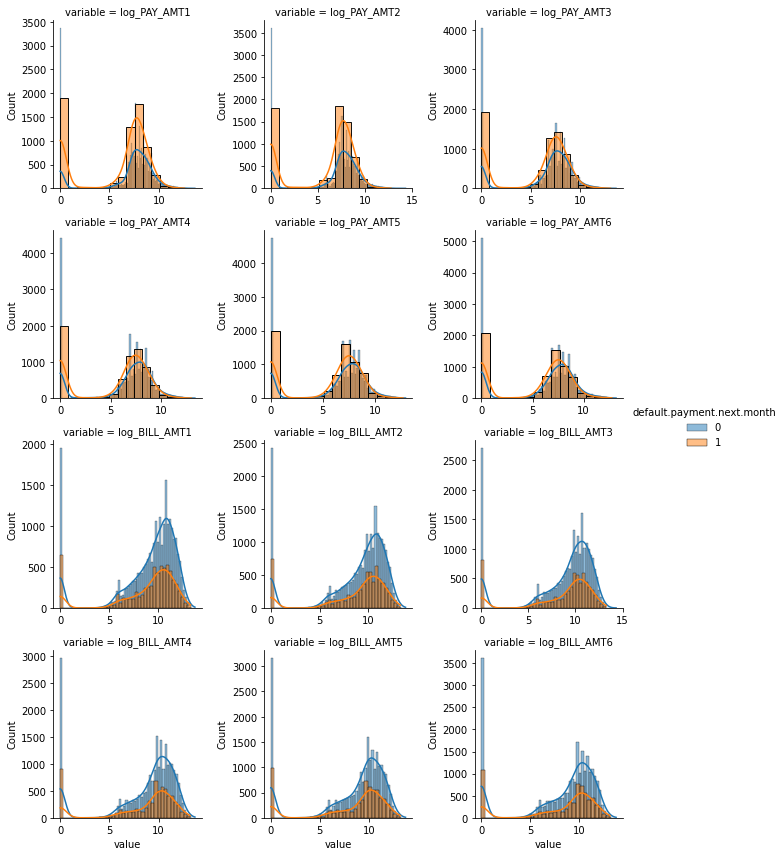

In [13]:
logged = []
for ii in range(1,7):
    qual_Enc.remove("PAY_AMT" + str( ii ))
    credit[ "log_PAY_AMT" + str( ii )]  = credit["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual_Enc.remove("BILL_AMT" + str( ii ))
    credit[ "log_BILL_AMT" + str( ii )] = credit["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( credit, id_vars=output, value_vars=logged)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.histplot, "value", kde=True).add_legend()

##### It looks like higher Log PAY_AMT is associated with slightly less default.



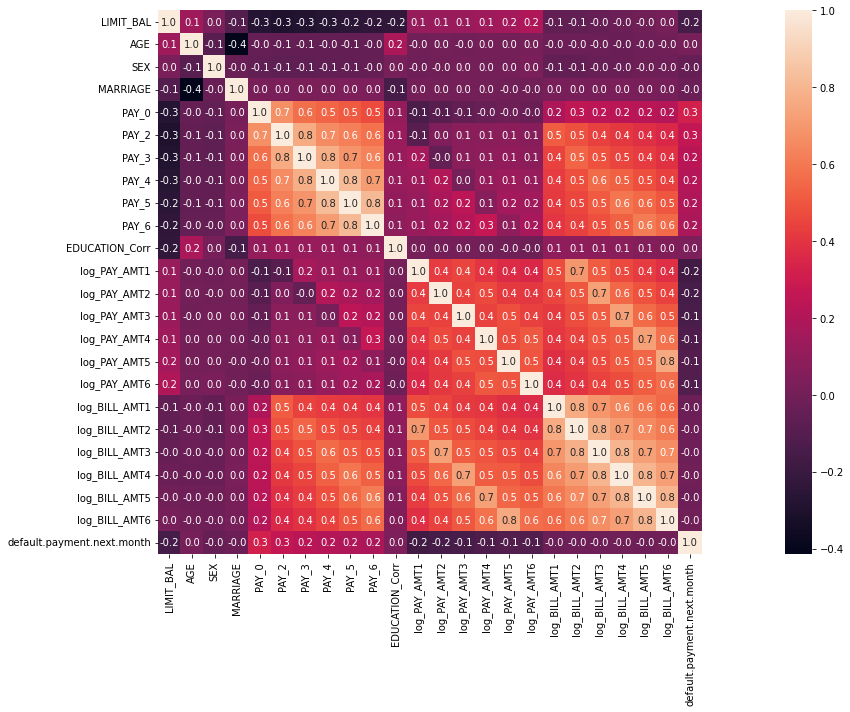

In [14]:
# So now we have quant variables, qual_Enc variables and logged variables.
# Let's look correlations with the output variable:
features = quant + qual_Enc + logged + [output]
corr = credit[features].corr()
plt.subplots(figsize=(30,10))
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )  

##### It looks like the PAY_0, PAY_X variables are the strongest predictors of default, followed by the LIMIT_BAL and Log_PAY_AMT variables.

In [15]:
# To make predictions about whether a customer is likely to default - we'll train a number of different classifiers
# and see how well they perform

features = quant + qual_Enc + logged   
X = credit[features].values    
y = credit[ output ].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

# Evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

##### **Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
score = cross_val_score(estimator = classifier, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 74.74 %
score1: 80.55 %


##### **Decision Tree**

In [17]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
score = cross_val_score(estimator = classifier_dt, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_dt, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 61.06 %
score1: 72.80 %


##### **Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
score = cross_val_score(estimator = classifier_rf, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_rf, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 72.97 %
score1: 80.50 %


##### **Support Vector Machine**

In [19]:
from sklearn.svm import SVC
classifier_sv = SVC(kernel = 'rbf', random_state = 0)
score = cross_val_score(estimator = classifier_sv, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_sv, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 71.78 %
score1: 81.62 %


##### **Naive Bayes**

In [21]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
score = cross_val_score(estimator = classifier_nb, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_nb, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 74.35 %
score1: 75.83 %


#### **KNN**

In [22]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kn = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p = 2)
score = cross_val_score(estimator = classifier_kn, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_kn, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 70.65 %
score1: 79.02 %


#####  **XGBoost**

In [23]:
from xgboost import XGBClassifier
classifier_xg = XGBClassifier()
score = cross_val_score(estimator = classifier_xg, scoring = 'roc_auc', X = X_train, y = y_train, cv = 10)
score1 = cross_val_score(estimator = classifier_xg, X = X_train, y = y_train, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 78.04 %
score1: 81.92 %


###### Random oversampling

In [24]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler() #Initialis the model 
X_ros, y_ros = ros.fit_resample(X, y) #Fit the model

In [25]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split( X_ros, y_ros, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train1 = scX.fit_transform( X_train1 )
X_test1 = scX.transform( X_test1 )

In [26]:
from xgboost import XGBClassifier
classifier_xg = XGBClassifier()
score = cross_val_score(estimator = classifier_xg, scoring = 'roc_auc', X = X_train1, y = y_train1, cv = 10)
score1 = cross_val_score(estimator = classifier_xg, X = X_train1, y = y_train1, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 79.90 %
score1: 72.36 %


###### smote

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)


In [28]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split( X_sm, y_sm, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train2 = scX.fit_transform( X_train2 )
X_test2 = scX.transform( X_test2 )

In [29]:
from xgboost import XGBClassifier
classifier_xg = XGBClassifier()
score = cross_val_score(estimator = classifier_xg, scoring = 'roc_auc', X = X_train2, y = y_train2, cv = 10)
score1 = cross_val_score(estimator = classifier_xg, X = X_train2, y = y_train2, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 92.61 %
score1: 86.73 %


#### **Hyperparameter Tuning**

In [30]:
param = {'learning_rate' : [0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25, 0.30, 0.5, 0.7, 1],
         'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
         'min_child_weight' : [1,2,3,4,5,6,7],
         'gamma' : [0.1,0.2,0.3,0.4,0.5,0.6],
         'colsample_bytree' : [0.3, 0.4, 0.5, 0.6, 0.7]}

In [31]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
classifier_xg = XGBClassifier()

random_search = RandomizedSearchCV(classifier_xg, param_distributions = param, n_iter = 5, scoring = 'roc_auc', n_jobs = -1, cv = 10)
random_search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=10, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7],
                                        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                                        'learning_rate': [0.05, 0.1, 0.11, 0.12,
                                                          0.13, 0.14, 0.15, 0.2,
                                                          0.25, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7]},
                   scoring='roc_auc')

In [32]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.4, gamma=0.1, max_depth=10)

In [33]:
x_g = XGBClassifier(colsample_bytree=0.7, gamma=0.4, max_depth=9)

In [34]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = x_g, scoring = 'roc_auc', X = X_train2, y = y_train2, cv = 10)
score1 = cross_val_score(estimator = x_g, X = X_train2, y = y_train2, cv = 10)
print("score_roc_auc: {:.2f} %".format(score.mean()*100))
print("score1: {:.2f} %".format(score1.mean()*100))

score_roc_auc: 93.51 %
score1: 87.60 %


In [37]:
x_g.fit(X_train2, y_train2)
pred = x_g.predict(X_test2)

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test2, pred)
print(cm)
accuracy = accuracy_score(y_test2, pred)
print('accuracy :', accuracy)
roc = roc_auc_score(y_test2, x_g.predict_proba(X_test2)[:, 1])
print('roc_auc :', roc )

[[4384  248]
 [ 951 3763]]
accuracy : 0.8717098223839076
roc_auc : 0.9340178778825868


**Conclusion**: Using a XGBOOST classifier, we can predict with ~87% accuracy, whether a customer is likely to default next month.

The strongest predictors of default are the  **PAY_X**  (ie the repayment status in previous months), the **LIMIT_BAL** & the **PAY_AMTX** (amount paid in previous months).

**Demographics:** we see that being Female, More educated, Single and between 30-40years old means a customer is more likely to make payments on time.